In [1]:
# STILE DI VISUALIZZAZIONE PLOT FATTI CON MATPLOTLIB
#%matplotlib widget
#
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from IPython.display import display
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 

Ora Scarico il dataset in modo che includa le persone che compaiono almeno un numero di volte specificato.

In [2]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=100, resize=0.45)

face_data = lfw_people['data']
face_images = lfw_people['images']
face_tnames = lfw_people['target_names']
face_targets = lfw_people['target']
display(face_tnames)

array(['Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'], dtype='<U17')

Ora Visualizzo la distribuzione di immagini nelle classi

<AxesSubplot:>

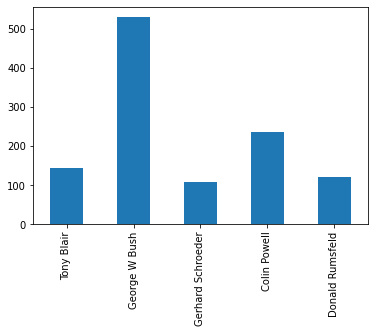

In [3]:
face_df = pd.DataFrame(face_targets)
face_df['target_names'] = [face_tnames[t] for t in face_df[0]]
face_df['target_names'].value_counts(sort = False).plot.bar()

In [4]:
random_state = 20212207
test_p = 0.4
val_p = 0.25  # Percentuale di dati di X_trainval da usare come validation set

X_trainval, X_test, y_trainval, y_test = train_test_split(face_data, face_targets, test_size=test_p, random_state=random_state, shuffle=True)

display(pd.DataFrame({'X_trainval': X_trainval.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

,X_trainval,X_test
N. sanmples,684,456
N.features,2352,2352


Ora analizzo la Distribuzione delle classi nelle parti di test e di training


[Text(0, 0, 'Colin Powell'),
 Text(1, 0, 'Donald Rumsfeld'),
 Text(2, 0, 'George W Bush'),
 Text(3, 0, 'Gerhard Schroeder'),
 Text(4, 0, 'Tony Blair')]

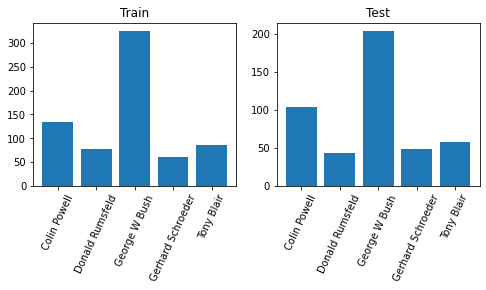

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].set_title('Train')

y_train_df = pd.DataFrame(y_trainval)

axs[0].bar(np.arange(len(face_tnames)), y_train_df[0].value_counts(sort = False))
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=65)

axs[1].set_title('Test')
y_test_df = pd.DataFrame(y_test)

axs[1].bar(np.arange(len(face_tnames)), y_test_df[0].value_counts(sort = False))
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=65)

Processo il dataset con la PCA

In [6]:
pca = PCA(0.8)

pca.fit(X_trainval)

display(pd.DataFrame({'Numero PC': pca.n_components_, 
                      '% Varianza Tot. Spiegata': pca.explained_variance_ratio_.sum()}, 
                     index=['X_trainval']))

X_trainval_old = X_trainval.copy()
X_trainval = pca.transform(X_trainval)

X_test_old = X_test.copy()
X_test = pca.transform(X_test)

,Numero PC,% Varianza Tot. Spiegata
X_trainval,29,0.803236


In [7]:
# Inizializzazione iper-parametri MLP
hidden_layer_sizes = [500]*2
activation = 'relu'
patience = 75
max_epochs = 5000
verbose = False
batch_sz = 4

# Inizializzazione MLP
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, batch_size=batch_sz, max_iter=max_epochs, early_stopping=True, n_iter_no_change=patience, random_state=random_state ,validation_fraction=val_p, solver= 'adam')

mlp_ros = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, batch_size=batch_sz, max_iter=max_epochs, early_stopping=True, n_iter_no_change=patience, random_state=random_state ,validation_fraction=val_p, solver= 'adam')

Cosa Faccio?  Mostro gli effetti con / senza

In [8]:
ros = RandomOverSampler(random_state= random_state)
X_trainval_ros, y_trainval_ros = ros.fit_resample(X_trainval, y_trainval)

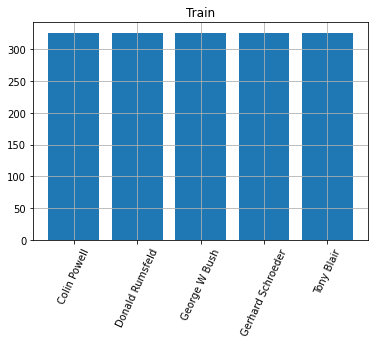

In [9]:
plt.figure()
plt.title('Train')

y_train_ros_df = pd.DataFrame(y_trainval_ros)

plt.bar(np.arange(len(face_tnames)), y_train_ros_df[0].value_counts(sort = False))
plt.xticks(np.arange(len(face_tnames)), labels = face_tnames, rotation = 65)
plt.grid()
plt.show()

Risultati

In [10]:
# Addestramento MLP
mlp.fit(X_trainval, y_trainval)
mlp_ros.fit(X_trainval_ros, y_trainval_ros)

MLPClassifier(batch_size=4, early_stopping=True, hidden_layer_sizes=[500, 500],
              max_iter=5000, n_iter_no_change=75, random_state=20212207,
              validation_fraction=0.25)

,Accuracy,Precision,Recall,F1
train. + val.,0.896199,0.906443,0.896199,0.896874
test,0.739035,0.751010,0.739035,0.736084


,Accuracy,Precision,Recall,F1
train. + val.,0.988957,0.989002,0.988957,0.988970
test,0.793860,0.790611,0.793860,0.789559


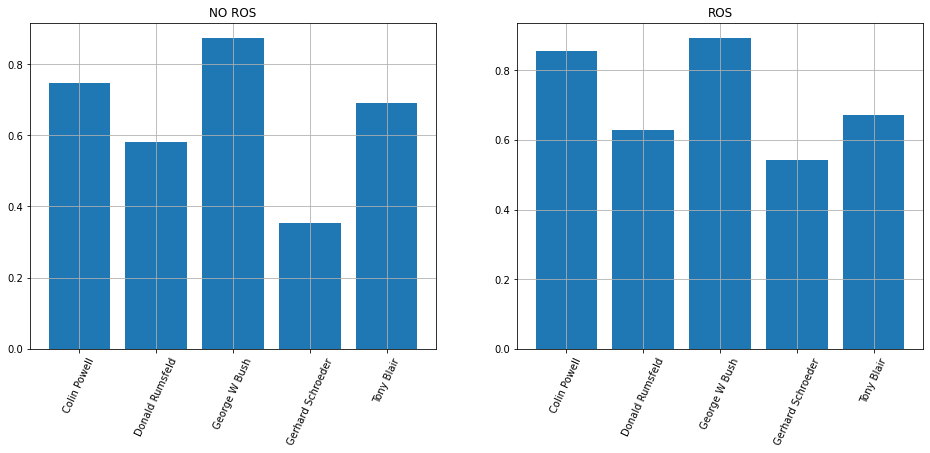

In [11]:
y_pred_trainval = mlp.predict(X_trainval)
y_pred = mlp.predict(X_test)

acc_trainval = mlp.score(X_trainval, y_trainval)
prec_trainval = precision_score(y_trainval, y_pred_trainval, average='weighted')
rec_trainval = recall_score(y_trainval, y_pred_trainval, average='weighted')
f1_trainval = f1_score(y_trainval, y_pred_trainval, average='weighted')

acc = mlp.score(X_test, y_test)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_trainval, acc], 
                        'Precision': [prec_trainval, prec], 
                        'Recall': [rec_trainval, rec],
                        'F1': [f1_trainval, f1]
                       },
                      index=['train. + val.', 'test'])

cmat = confusion_matrix(y_test, y_pred, labels=mlp.classes_)
cmat_norm_true = confusion_matrix(y_test, y_pred, labels=mlp.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_test, y_pred, labels=mlp.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=face_tnames, index=face_tnames)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=face_tnames, index=face_tnames)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=face_tnames, index=face_tnames)

y_pred_trainval_ros = mlp_ros.predict(X_trainval_ros)
y_pred_ros = mlp_ros.predict(X_test)

acc_trainval_ros = mlp_ros.score(X_trainval_ros, y_trainval_ros)
prec_trainval_ros = precision_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')
rec_trainval_ros = recall_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')
f1_trainval_ros = f1_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')

acc_ros = mlp_ros.score(X_test, y_test)
prec_ros = precision_score(y_test, y_pred_ros, average='weighted')
rec_ros = recall_score(y_test, y_pred_ros, average='weighted')
f1_ros = f1_score(y_test, y_pred_ros, average='weighted')

df_perf_ros = pd.DataFrame({'Accuracy': [acc_trainval_ros, acc_ros], 
                        'Precision': [prec_trainval_ros, prec_ros], 
                        'Recall': [rec_trainval_ros, rec_ros],
                        'F1': [f1_trainval_ros, f1_ros]
                       },
                      index=['train. + val.', 'test'])

cmat_ros = confusion_matrix(y_test, y_pred_ros, labels=mlp.classes_)
cmat_norm_true_ros = confusion_matrix(y_test, y_pred_ros, labels=mlp.classes_, normalize='true')
cmat_norm_pred_ros = confusion_matrix(y_test, y_pred_ros, labels=mlp.classes_, normalize='pred')

display(df_perf)
display(df_perf_ros)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title('NO ROS')

axs[0].bar(np.arange(len(face_tnames)), [cmat_norm_true[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=65)
axs[0].grid()

axs[1].set_title('ROS')

axs[1].bar(np.arange(len(face_tnames)), [cmat_norm_true_ros[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=65)
axs[1].grid()
#display(df_cmat)
#display(df_cmat_norm_true)
#display(df_cmat_norm_pred)

Errors

array([[ 77,   2,  17,   0,   7],
       [  5,  25,   9,   2,   2],
       [  6,   3, 178,   4,  13],
       [  0,   2,   6,  17,  23],
       [  2,   0,  11,   5,  40]])

array([[ 88,   4,   8,   0,   3],
       [  4,  27,   8,   1,   3],
       [  8,   4, 182,   4,   6],
       [  3,   3,   9,  26,   7],
       [  3,   1,  12,   3,  39]])

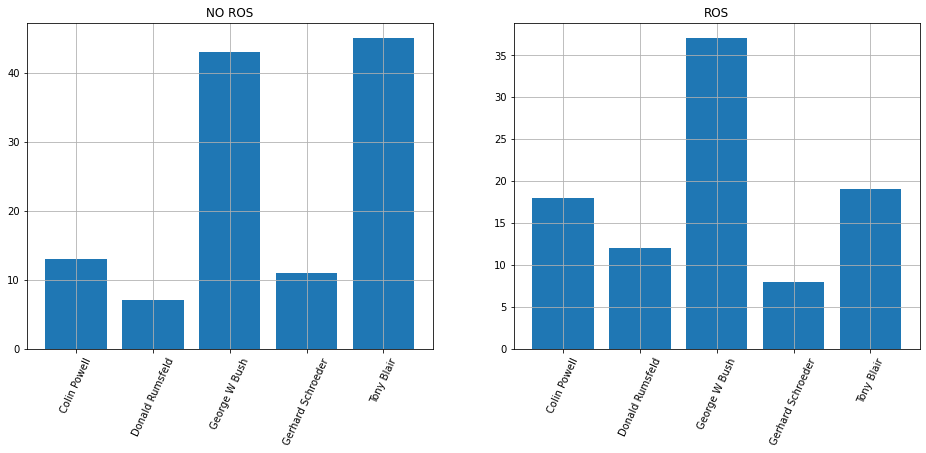

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].set_title('NO ROS')

axs[0].bar(np.arange(len(face_tnames)), [np.sum(cmat[:,t]) -cmat[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=65)
axs[0].grid()

axs[1].set_title('ROS')

axs[1].bar(np.arange(len(face_tnames)), [np.sum(cmat_ros[:,t]) -cmat_ros[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=65)
axs[1].grid()

display(cmat)
display(cmat_ros)